In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import warnings 
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools
from sklearn.metrics import mean_squared_error as mse

In [2]:
df = pd.read_csv(r"data\model_input.csv")
dataset = df.drop(columns=["Unnamed: 0", "Min Temp", "Max Temp", "percentile_25", "percentile_75"])
dataset

,Mean Temp,RAINFALL,month_year,median
0,22.178833,0.085958,2013-04,0.455720
1,26.819516,0.413366,2013-05,0.665620
2,25.359833,31.586529,2013-06,0.226039
3,25.052258,20.653476,2013-07,0.249820
4,24.369032,24.446940,2013-08,0.267682
...,...,...,...,...
112,25.292838,13.266669,2022-08,0.238900
113,23.823002,11.473897,2022-09,0.244405
114,20.420344,3.875470,2022-10,0.419238
115,16.548313,0.000000,2022-11,0.518314


In [3]:
dataset['month_year'] = pd.to_datetime(dataset['month_year'])
dataset['year'] = dataset['month_year'].dt.year
dataset['month'] = dataset['month_year'].dt.month
ts_dataset = dataset.drop(columns=["month_year"])
ts_dataset

,Mean Temp,RAINFALL,median,year,month
0,22.178833,0.085958,0.455720,2013,4
1,26.819516,0.413366,0.665620,2013,5
2,25.359833,31.586529,0.226039,2013,6
3,25.052258,20.653476,0.249820,2013,7
4,24.369032,24.446940,0.267682,2013,8
...,...,...,...,...,...
112,25.292838,13.266669,0.238900,2022,8
113,23.823002,11.473897,0.244405,2022,9
114,20.420344,3.875470,0.419238,2022,10
115,16.548313,0.000000,0.518314,2022,11


In [4]:
ts_dataset['timeindex'] = (ts_dataset['year'] - 2013)*12 + ts_dataset['month'] - 3
ts_dataset.drop(columns = ['year', 'month'], inplace=True)

In [5]:
median = ts_dataset['median']
ts_dataset.drop(columns='median', inplace=True)
ts_dataset['Median NDSI'] = median
ts_dataset

,Mean Temp,RAINFALL,timeindex,Median NDSI
0,22.178833,0.085958,1,0.455720
1,26.819516,0.413366,2,0.665620
2,25.359833,31.586529,3,0.226039
3,25.052258,20.653476,4,0.249820
4,24.369032,24.446940,5,0.267682
...,...,...,...,...
112,25.292838,13.266669,113,0.238900
113,23.823002,11.473897,114,0.244405
114,20.420344,3.875470,115,0.419238
115,16.548313,0.000000,116,0.518314


In [6]:
arima_dataset = ts_dataset.drop(columns=["Mean Temp", "RAINFALL"])
arima_dataset

,timeindex,Median NDSI
0,1,0.455720
1,2,0.665620
2,3,0.226039
3,4,0.249820
4,5,0.267682
...,...,...
112,113,0.238900
113,114,0.244405
114,115,0.419238
115,116,0.518314


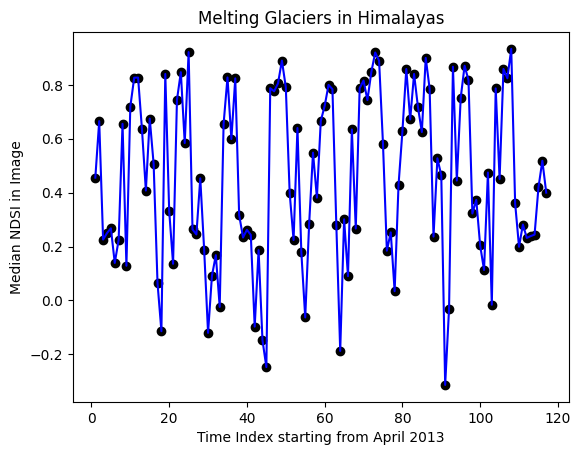

In [8]:
x = arima_dataset['timeindex']
y= arima_dataset['Median NDSI']
plt.plot(x, y, c = 'blue')
plt.scatter(x, y, c = 'black')
plt.xlabel("Time Index starting from April 2013")
plt.ylabel("Median NDSI in Image")
plt.title("Melting Glaciers in Himalayas")
plt.show()

In [10]:
result1 = adfuller(arima_dataset['Median NDSI'])
result1
# If p-value > 0.05, the series is not stationary

(-1.845308580329862,
 0.3582103719315229,
 11,
 105,
 {'1%': -3.4942202045135513,
  '5%': -2.889485291005291,
  '10%': -2.5816762131519275},
 14.097917048274866)

In [14]:
result2 = sm.tsa.stattools.kpss(arima_dataset['Median NDSI'], regression='ct')
result2
# If p-value < 0.05, the series is not stationary

C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_69664\2406077758.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result2 = sm.tsa.stattools.kpss(arima_dataset['Median NDSI'], regression='ct')


(0.04316002196408604,
 0.1,
 4,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

<Axes: >

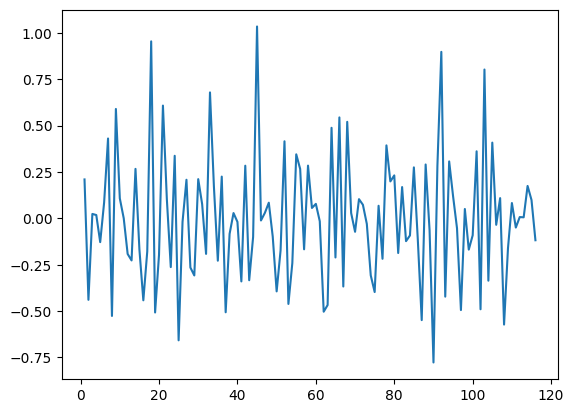

In [15]:
diff1 = arima_dataset['Median NDSI'].diff().dropna()
diff1.plot()

In [16]:
result3 = adfuller(diff1)
result3

(-6.732153242922841,
 3.2753347414858138e-09,
 12,
 103,
 {'1%': -3.4954932834550623,
  '5%': -2.8900369024285117,
  '10%': -2.5819706975209726},
 13.795287687547471)

In [33]:
train = arima_dataset[:-12]
test = arima_dataset[-12:]

In [35]:
p = q = range(0, 13)
d = [1,2]

# Generate all different combinations of p, d, q triplets
pdq = list(itertools.product(p, d, q))

rmse = []
params = []

for param in tqdm.tqdm(pdq, desc="Grid Search for ARIMA"):
    try:
        model = ARIMA(train['Median NDSI'], order=param)
        model_fit = model.fit()
        model_pred = model_fit.predict(start=len(train), end=(len(df) - 1))
        error = np.sqrt(mse(test['Median NDSI'], model_pred))
        params.append(param)
        rmse.append(error)

    except Exception as e:
        pass

results = pd.DataFrame(index=params, data=rmse, columns=['RMSE'])

results = results.sort_values(by='RMSE')

Grid Search for ARIMA:   1%|▏         | 5/338 [00:00<00:36,  9.17it/s]c:\Users\Pranav Koka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Grid Search for ARIMA:   3%|▎         | 9/338 [00:01<01:25,  3.85it/s]c:\Users\Pranav Koka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Grid Search for ARIMA:   3%|▎         | 10/338 [00:02<01:53,  2.90it/s]c:\Users\Pranav Koka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Grid S

In [36]:
results

,RMSE
"(12, 2, 0)",0.139635
"(3, 1, 12)",0.153724
"(4, 1, 12)",0.155579
"(8, 2, 2)",0.157097
"(10, 1, 0)",0.157149
...,...
"(3, 2, 0)",0.647317
"(4, 2, 0)",0.651418
"(0, 2, 11)",0.663374
"(1, 2, 0)",0.803547


In [37]:
model = ARIMA(train['Median NDSI'], order=(12,2,0))
model_fit = model.fit()

In [38]:
model_pred = model_fit.predict(start = len(train), end = (len(arima_dataset)-1))
model_pred

105    0.612078
106    0.546079
107    0.744572
108    0.463642
109    0.297122
110    0.341577
111    0.194055
112    0.238877
113    0.294172
114    0.361374
115    0.457395
116    0.558216
Name: predicted_mean, dtype: float64

In [40]:
test['Median NDSI']

105    0.859192
106    0.824354
107    0.933460
108    0.360349
109    0.199212
110    0.281751
111    0.232020
112    0.238900
113    0.244405
114    0.419238
115    0.518314
116    0.400156
Name: Median NDSI, dtype: float64

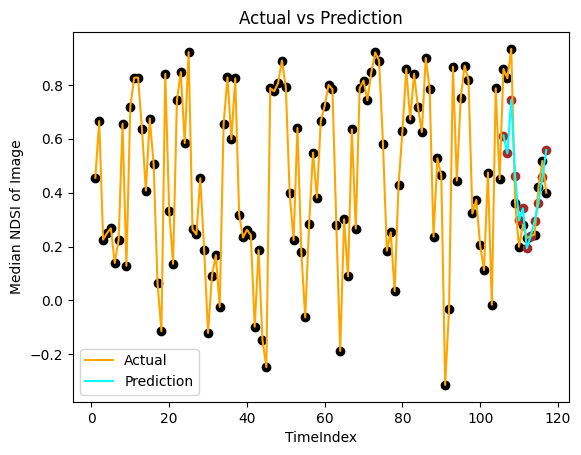

In [39]:
plt.plot(arima_dataset['timeindex'], arima_dataset['Median NDSI'], c = 'orange')
plt.plot(test['timeindex'], model_pred, c = 'cyan')
plt.scatter(arima_dataset['timeindex'], arima_dataset['Median NDSI'], c = 'black')
plt.scatter(test['timeindex'], model_pred, c = 'brown')
plt.xlabel("TimeIndex")
plt.ylabel("Median NDSI of Image")
plt.title("Actual vs Prediction")
plt.legend(["Actual", "Prediction"])
plt.show()

In [ ]:
ts_dataset

,Mean Temp,RAINFALL,timeindex,Median NDSI
0,22.178833,0.085958,1,0.455720
1,26.819516,0.413366,2,0.665620
2,25.359833,31.586529,3,0.226039
3,25.052258,20.653476,4,0.249820
4,24.369032,24.446940,5,0.267682
...,...,...,...,...
112,25.292838,13.266669,113,0.238900
113,23.823002,11.473897,114,0.244405
114,20.420344,3.875470,115,0.419238
115,16.548313,0.000000,116,0.518314


In [54]:
result4 = adfuller(ts_dataset['Mean Temp'])
result4
# If p-value > 0.05, the series is not stationary

(-1.3002025817123515,
 0.6290796272051388,
 11,
 105,
 {'1%': -3.4942202045135513,
  '5%': -2.889485291005291,
  '10%': -2.5816762131519275},
 309.9523976376393)

<Axes: >

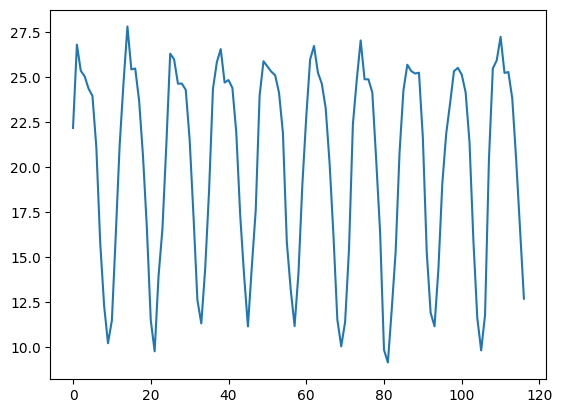

In [44]:
ts_dataset['Mean Temp'].plot()

In [50]:
for lag in range(1, 13):  # Test lags 1 to 12
    ts_diff = ts_dataset['Mean Temp'].diff(lag)
    ts_diff.dropna(inplace=True)
    adf_test = adfuller(ts_diff)
    print(f"Lag {lag}, ADF p-value: {adf_test[1]}")


Lag 1, ADF p-value: 1.0814955491683104e-19
Lag 2, ADF p-value: 4.432490727834413e-21
Lag 3, ADF p-value: 7.412543355986527e-05
Lag 4, ADF p-value: 4.1859199276498854e-09
Lag 5, ADF p-value: 0.012516631455170173
Lag 6, ADF p-value: 2.0990282479848998e-10
Lag 7, ADF p-value: 0.007987333778620372
Lag 8, ADF p-value: 0.07374079909624048
Lag 9, ADF p-value: 0.1913828704170425
Lag 10, ADF p-value: 0.41281967150499566
Lag 11, ADF p-value: 0.2727026048827973
Lag 12, ADF p-value: 0.3598989608893861


<Axes: >

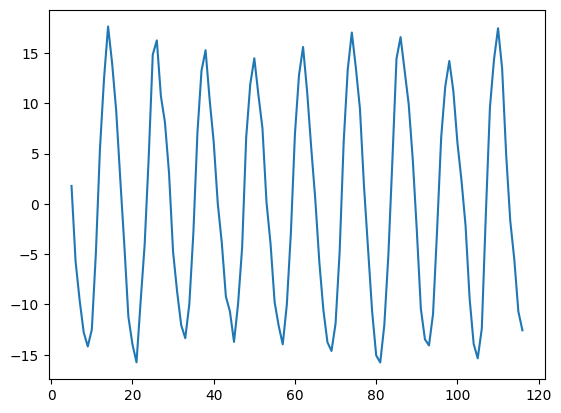

In [57]:
ts_diff_temp = ts_dataset['Mean Temp'].diff(5)
ts_diff_temp.dropna(inplace=True)
ts_diff_temp.plot()

In [55]:
result5 = adfuller(ts_dataset['RAINFALL'])
result5
# If p-value > 0.05, the series is not stationary

(-2.7960304268516785,
 0.05884303439217425,
 11,
 105,
 {'1%': -3.4942202045135513,
  '5%': -2.889485291005291,
  '10%': -2.5816762131519275},
 575.2519711996994)

<Axes: >

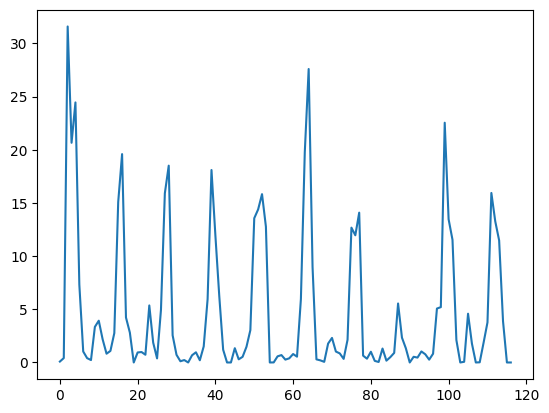

In [52]:
ts_dataset['RAINFALL'].plot()

In [56]:
for lag in range(1, 13):  # Test lags 1 to 12
    ts_diff = ts_dataset['RAINFALL'].diff(lag)
    ts_diff.dropna(inplace=True)
    adf_test = adfuller(ts_diff)
    print(f"Lag {lag}, ADF p-value: {adf_test[1]}")

Lag 1, ADF p-value: 2.39963208296417e-09
Lag 2, ADF p-value: 0.0002721640343020601
Lag 3, ADF p-value: 4.98691323141593e-10
Lag 4, ADF p-value: 2.3717909829458197e-09
Lag 5, ADF p-value: 0.02503563522058304
Lag 6, ADF p-value: 1.4021293412335485e-09
Lag 7, ADF p-value: 0.005072806081778306
Lag 8, ADF p-value: 0.01580825959866088
Lag 9, ADF p-value: 0.050582559793161994
Lag 10, ADF p-value: 0.06838944161865736
Lag 11, ADF p-value: 0.04310167928353838
Lag 12, ADF p-value: 0.1521469190282051


<Axes: >

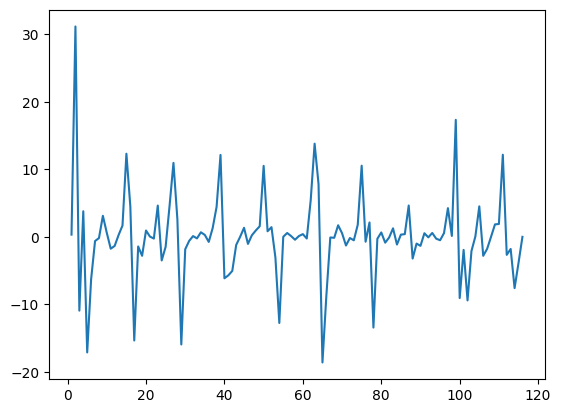

In [59]:
ts_diff_rain = ts_dataset['RAINFALL'].diff(1)
ts_diff_rain.dropna(inplace=True)
ts_diff_rain.plot()